In [2]:
import os, signal, zipfile, random
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O '/content/drive/MyDrive/Colab Notebooks/TSF/Resources/cats_and_dogs/cats_and_dogs_filtered.zip'

# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O '/content/drive/MyDrive/Colab Notebooks/TSF/Resources/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

--2021-03-20 00:02:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 172.217.2.112, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   159MB/s    in 0.4s    

2021-03-20 00:02:48 (159 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
local_zip = '/content/drive/MyDrive/Colab Notebooks/TSF/Resources/cats_and_dogs/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/TSF/Resources/cats_and_dogs')
zip_ref.close()

In [9]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/TSF/Resources/cats_and_dogs/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


In [10]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [11]:
nrows = 4
ncols = 4
pic_index = 0

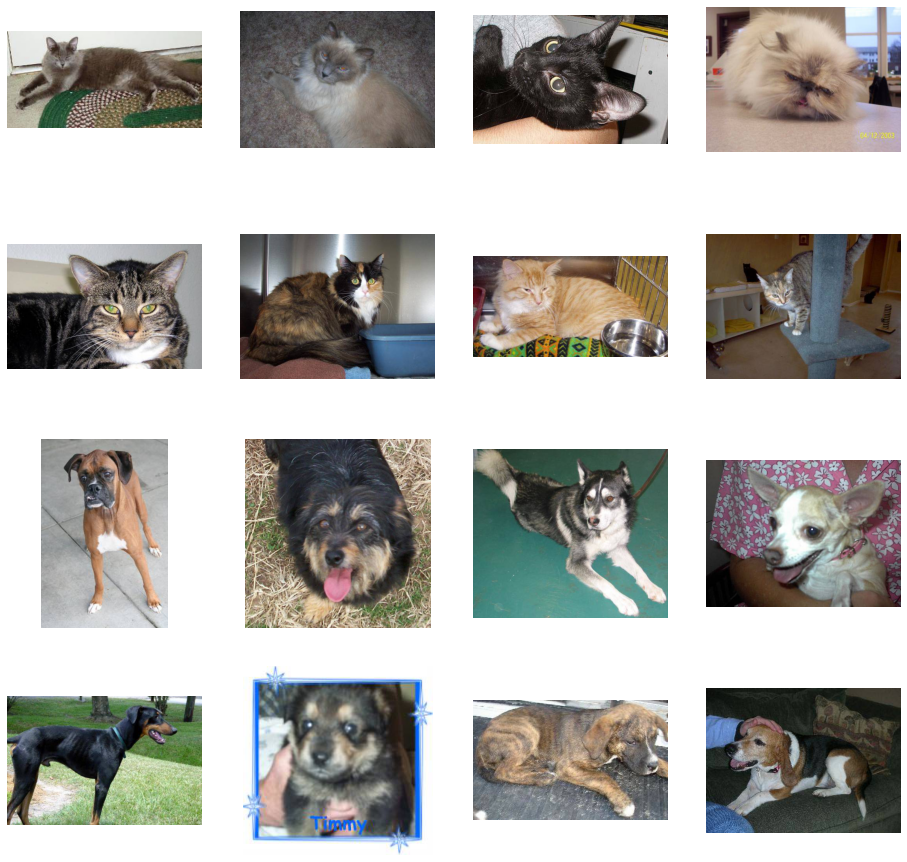

In [12]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.8,1.2],
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
local_weights_file = '/content/drive/MyDrive/Colab Notebooks/TSF/Resources/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [16]:
pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3),
    weights = None,
    include_top = False
)

for layer in pre_trained_model.layers:
  layer.trainable = False
  if layer.name == 'mixed7':
    break

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
last_layer = pre_trained_model.get_layer("mixed10")
last_output = last_layer.output

In [18]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

In [19]:
model = Model(pre_trained_model.input, x)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
class StopOnAccuracy(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

stop = StopOnAccuracy()

In [23]:
starting_lr = 1e-4

lr_epochs = 10

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: starting_lr * 10 ** (2 * (epoch / lr_epochs)))

In [29]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(lr=starting_lr),
    metrics = ['accuracy']
)

In [30]:
lr_history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = lr_epochs,
    callbacks = [lr_schedule]
)

Epoch 1/10
100/100 [==============================] - 22s 173ms/step - loss: 0.6948 - accuracy: 0.5064
Epoch 2/10
100/100 [==============================] - 17s 174ms/step - loss: 0.6885 - accuracy: 0.5449
Epoch 3/10
100/100 [==============================] - 17s 175ms/step - loss: 0.6751 - accuracy: 0.5777
Epoch 4/10
100/100 [==============================] - 17s 172ms/step - loss: 0.6684 - accuracy: 0.6098
Epoch 5/10
100/100 [==============================] - 18s 176ms/step - loss: 0.6700 - accuracy: 0.5881
Epoch 6/10
100/100 [==============================] - 17s 173ms/step - loss: 0.6654 - accuracy: 0.5971
Epoch 7/10
100/100 [==============================] - 18s 178ms/step - loss: 0.6636 - accuracy: 0.6114
Epoch 8/10
100/100 [==============================] - 18s 176ms/step - loss: 0.6789 - accuracy: 0.5816
Epoch 9/10
100/100 [==============================] - 17s 174ms/step - loss: 0.6662 - accuracy: 0.6084
Epoch 10/10
100/100 [==============================] - 17s 173ms/step - l

(0.0001, 0.01, 0.0, 0.6)

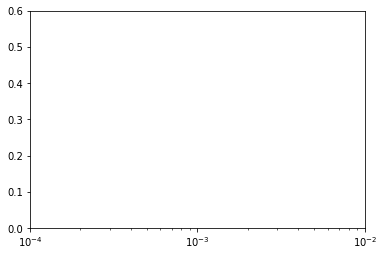

In [28]:
lrs = starting_lr * (10 ** (2 * np.arange(lr_epochs) / lr_epochs))
plt.semilogx(lrs, lr_history.history["loss"])
plt.axis([starting_lr, starting_lr * (10 ** 2), 0, 0.6])

In [27]:
model = Model(pre_trained_model.input, x)

model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = 50
)

model.save('/content/drive/MyDrive/Colab Notebooks/TSF/Models/cat_dog_model_30')

Epoch 1/10
100/100 [==============================] - 30s 300ms/step - loss: 0.1566 - accuracy: 0.9450 - val_loss: 0.2710 - val_accuracy: 0.9240
Epoch 2/10
100/100 [==============================] - 30s 299ms/step - loss: 0.1463 - accuracy: 0.9515 - val_loss: 0.1658 - val_accuracy: 0.9330
Epoch 3/10
100/100 [==============================] - 30s 298ms/step - loss: 0.1427 - accuracy: 0.9530 - val_loss: 0.2763 - val_accuracy: 0.9160
Epoch 4/10
100/100 [==============================] - 30s 298ms/step - loss: 0.1445 - accuracy: 0.9535 - val_loss: 0.2750 - val_accuracy: 0.9360
Epoch 5/10
100/100 [==============================] - 30s 297ms/step - loss: 0.1374 - accuracy: 0.9530 - val_loss: 0.1584 - val_accuracy: 0.9410
Epoch 6/10
100/100 [==============================] - 30s 300ms/step - loss: 0.1280 - accuracy: 0.9565 - val_loss: 0.2409 - val_accuracy: 0.9300
Epoch 7/10
100/100 [==============================] - 30s 297ms/step - loss: 0.1411 - accuracy: 0.9555 - val_loss: 0.1870 - val_ac

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'r')
plt.title('Training and validation loss')

NameError: ignored

In [ ]:
model =  tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/TSF/Models/cat_dog_model_20')

In [1]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

NameError: ignored

In [ ]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

KeyboardInterrupt: ignored